# Example 1: Basic usage


Fisrt of all, we need to install Docker/Docker Desktop.

- [How to install Docker on Linux?](https://envdes.github.io/clmu-app/container/install_docker.html)
- [How to install Docker Desktop](https://www.docker.com/products/docker-desktop/)
  
Platform: arm64/amd64


In [1]:
from pyclmuapp import usp_clmu
import matplotlib.pyplot as plt
import os

## usp mode: user forcing mode

workflow

1. initialize

note: the docker container (named **myclmu**) should be running and bind the input_path, output_path, log_path and scripts_path. if not use the `usp.docker(cmd='run')` to start the container, this will help to bind above paths automatically.

2. check domian
   
3. check forcing
   must define the forcing file

4. run case

---

Using `ups_clmu()` will initiate the usp_clmu class. The class will take the following parameters:

- The inputfolder, outputfolder, logfolder, and scriptfolder will be checked in the current working directory.
- If the folder does not exist, it will be created.
- User can specify the folders by using the inputfolder, outputfolder, logfolder, and scriptfolder parameters.
- Inputfolder, outputfolder, logfolder, and scriptfolder parameters are optional.



Here we use the `RUN_TYPE= "branch"` to avoid the repeated spinup phases.

The case (`usp_spinup`) is run for 10 years to spinup the model.

How to get `usp_spinup` ?

```python
usp_spinup = usp.run(
            output_prefix= "_clm.nc",
            case_name = "usp_spinup", 
            RUN_STARTDATE = "2002-01-01",
            STOP_OPTION = "nyears", 
            STOP_N = "10",
            RUN_TYPE= "coldstart",
            iflog = True,
            logfile = "log.log",
            #var_add= "'Qle','Qh','Qtau','Qstor','Rnet','SWup','LWup'",
            run_tyep="usp-exec"#"case", when docker container is not start)
        )
usp_spinup
```

make sure your `myclmu` container is running.

In [2]:
# initialize
usp = usp_clmu(
    pwd=os.getcwd(),
    container_type='docker')

# before running container, you need the image
# usp.docker("pull") # to pull the docker image if you don't have it

usp.docker("run") # run the docker container

Folder 'inputfolder' already exists.
Folder 'outputfolder' already exists.
Folder 'logfolder' already exists.
Folder 'scriptsfolder' already exists.
Folder '/Users/user/Documents/GitHub/pyclmuapp/docs/notebooks/usp/inputfolder/usp' already exists.


In [3]:
%%time

# check surface
usp.check_surf() # use the default surface data of London
# use usp.check_surf(usr_surf="sufdata.nc") to use the user provided surface data

# check the domain
# the domain file will be revised according to the surface data if usr_domain is not provided
# do this after check_surf
# because the surfdata should be provided to read the domain file
usp.check_domain()

# check the forcing
# this forcing derived from urban-plumber forcing data
usp.check_forcing(
    usr_forcing="forcing.nc")

usp_london = usp.run(
            output_prefix= "_clm.nc",
            case_name = "example1", 
            RUN_STARTDATE = "2012-01-01",
            STOP_OPTION = "nyears", 
            STOP_N = "2",
            RUN_TYPE= "branch",
            RUN_REFCASE= "usp_spinup", # the case name of the spinup run
            RUN_REFDATE= "2012-01-01",
            iflog = True,
            logfile = "log.log",
            hist_type = "'GRID','COLS'",
            run_tyep="usp-exec"#"case", when docker container is not start)
        )
usp_london

Copying the file forcing.nc to the /Users/user/Documents/GitHub/pyclmuapp/docs/notebooks/usp/inputfolder/usp
CPU times: user 245 ms, sys: 71 ms, total: 316 ms
Wall time: 2min 44s


['/Users/user/Documents/GitHub/pyclmuapp/docs/notebooks/usp/outputfolder/lnd/hist/example1_clm0_2024-09-24_14-02-31_clm.nc',
 '/Users/user/Documents/GitHub/pyclmuapp/docs/notebooks/usp/outputfolder/lnd/hist/example1_clm1_2024-09-24_14-02-31_clm.nc']



**There are three main steps to above code:**

`usp.check_surf()` will show what is available in the surfdata_dict.

to see what care mainly contained in surfdata.

```python
surf = usp.check_surf()
print(surf)
```

Args:

- usr_surfdata (str): The path to the user-defined surface data file. The default is None.

- surfata_name (str): The name of the surface data file. The default is "surfdata.nc".

- urban_type (int): The type of the urban surface. The default is 2. 0 is for TBD urban, 1 is for HD urban, and 2 is for MD urban



Please check below output to see:

1. what kind of urban parameter will need to run the single point model

2. The values list indicates different paramter in different level

   - list of albedo indicate the albedo of visable and invisable solar bands (VIS,NIR)
  
   - list of thermal paramters indicates the layer

---

`usp.check_domain()`

if you have your domain file, use `usp.check_domain(usr_domain=your-filepath)`

other parameters:
- usr_domain (str): The path to the user-defined domain data file. The default is None,which - means using the default domain data (UK-Kin site).
- lat (float): The latitude of the domain. The default is None. Provide it to change to your interest point.
- lon (float): The longitude of the domain. The default is None. Provide it to change to your interest point.

---

**check the forcing file**

`usp.check_forcing`

we need to provdie our own forcing data

if the forcing file is not in inputfolder/usp, then it will be copied to the inputfolder/usp

Args:
- usr_forcing (str): The path to the user-defined forcing data file. The default is None.
- action (dict): The dictionary of the revised forcing data for the urban surface parameters. The default is None, which means no action.
- mode (str): The mode for the revision. The default is "add".
- forcing_name (str): The name of the revised forcing data file. The default is "forcing.nc".

the forcing should be included:

1.  Zbot : Measurement height above ground m
2.  Prectmms : Precip_rate kg/m2/s
3.  Wind : Wind m/s
4.  LWdown : Downward longwave radiation at measurement height W/m2
5.  PSurf : Air pressure at measurement height Pa
6.  Qair : Specific humidity at measurement height, Kg/Kg
7.  Tair : Air temperature at measurement height K
8.  SWdown : Downward shortwave radiation at measurement height W/m2

Note: 
- Wind=sqrt(Wind_N^2 + Wind_E^2 )
- Prectmms=Snow+Rain

Make sure the forcing file is same as the protocols of CLM

---

**Plotting**

Note: ploting with time will need the `nc-time-axis` package, which can be installed by `pip install nc-time-axis` or `conda install nc-time-axis`

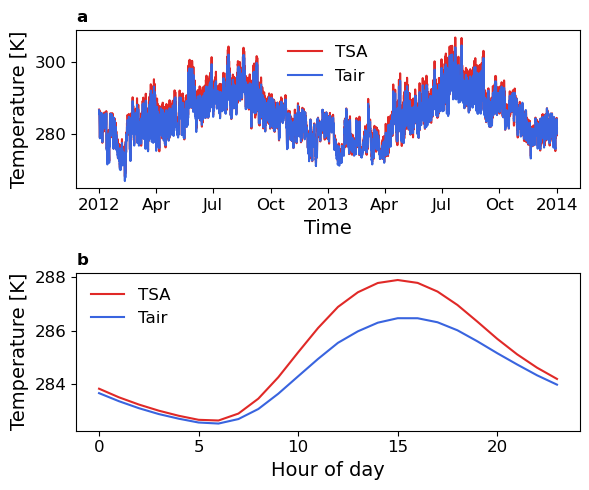

CPU times: user 1.33 s, sys: 306 ms, total: 1.63 s
Wall time: 1.84 s


In [4]:
%%time
ds_usp=usp.nc_view(usp_london[1]).isel(time=slice(2, None))
#ds_usp['time'] = ds_usp['time'].dt.round('min')
ds_usp_hour = ds_usp['TSA'].isel(gridcell=0).groupby('time.hour')
mean_tsa = ds_usp_hour.mean('time')
var_tsa = ds_usp_hour.var('time')

ds_usp_hour = ds_usp['TBOT'].isel(gridcell=0).groupby('time.hour')
mean_tbot = ds_usp_hour.mean('time')
var_tbot = ds_usp_hour.var('time')

fig = plt.figure(figsize=(6, 5))

ax = fig.add_subplot(211)
ds_usp['TSA'].isel(gridcell=0).plot(ax=ax, label='TSA', color='#E02927')#["#E02927","#3964DF"]
ds_usp['TBOT'].isel(gridcell=0).plot(ax=ax, label='Tair', color='#3964DF')

ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Temperature [K]', fontsize=14)
ax.set_title('a', loc='left', fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(frameon=False, fontsize=12)

ax = fig.add_subplot(212)
mean_tsa.plot(ax=ax, label='TSA', color='#E02927')
mean_tbot.plot(ax=ax, label='Tair', color='#3964DF')
ax.set_xlabel('Hour of day', fontsize=14)
ax.set_ylabel('Temperature [K]', fontsize=14)
ax.set_title('b', loc='left', fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(frameon=False, fontsize=12)

plt.tight_layout()
plt.savefig('figs/exp1_usp.pdf', dpi=300)
plt.show()

**plot other urban variables**

**radiation balance**
$$Rnet(Q\text{*})=SWdown-SWup-LWdown-LWup$$

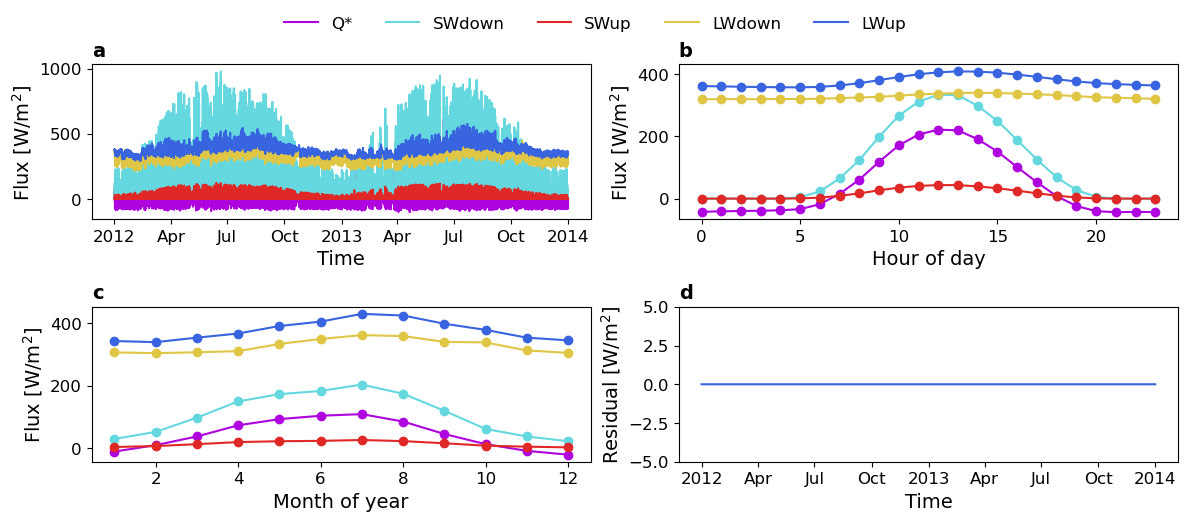

In [5]:
fig = plt.figure(figsize=(12, 5))

axs = fig.subplots(2, 2)

ds_usp_h = ds_usp[['Rnet','SWdown','SWup','LWdown','LWup']].isel(gridcell=0).groupby('time.hour')
h = ds_usp_h.mean('time')
color_list = ["#AE02DE", "#65D8DF","#E02927","#E0C645","#3964DF"]

ds_usp_month = ds_usp[['Rnet','SWdown','SWup','LWdown','LWup']].isel(gridcell=0).groupby('time.month')
m = ds_usp_month.mean('time')

for i, var in enumerate(['Rnet','SWdown','SWup','LWdown','LWup']):
    if var == 'Rnet':
        label = 'Q*'
    else:
        label = var
    ds_usp[var].plot(ax=axs[0,0], label=label, color=color_list[i])
    m[var].plot(ax=axs[1,0], label=label, color=color_list[i], marker='o')
    h[var].plot(ax=axs[0,1], label=label, color=color_list[i], marker='o')

(ds_usp['SWdown'] + ds_usp['LWdown'] - ds_usp['Rnet'] - ds_usp['SWup'] -ds_usp['LWup'] ).plot(ax=axs[1,1], color='#3964DF')

xlabels = ['Time', 'Hour of day', 'Month of year', 'Time']
ylabels = ['Flux [W/m$\mathrm{^{2}}$]', 'Flux [W/m$\mathrm{^{2}}$]', 'Flux [W/m$\mathrm{^{2}}$]', 'Residual [W/m$\mathrm{^{2}}$]']
titles = ['a', 'b', 'c', 'd']
for ax in axs.flat:
    ax.set_xlabel(xlabels.pop(0), fontsize=14)
    ax.set_ylabel(ylabels.pop(0), fontsize=14)
    ax.set_title(titles.pop(0), loc='left', fontweight='bold', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
axs[1,1].set_ylim(-5,5)
fig.legend(['Q*','SWdown','SWup','LWdown','LWup'], 
           loc="upper center", frameon=False, ncol=5, 
           bbox_to_anchor=(0.5, 1.05), fontsize=12)

plt.tight_layout()
plt.savefig('figs/exp1_usp_rad.pdf', dpi=300, bbox_inches='tight')
plt.show()

**energy balance**
$$Q\text{*} + Qanth=Qle-Qh-Qstor$$
$$Q\text{*}=Rnet$$
$$Qanth=WASTEHEAT+URBAN_HEAT$$
$$Qstor=FGR+URBAN_HEAT-URBAN_AC$$

- Qanth: anthropogenic heat flux
- Qle: latent heat flux
- Qh: sensible heat flux
- Qstor: storage heat flux
- WASTEHEAT: wasteheat flux from heating and air conditioning flux
- URBAN_HEAT: urban heating flux
- URBAN_AC: heat flux from urban air conditioning 

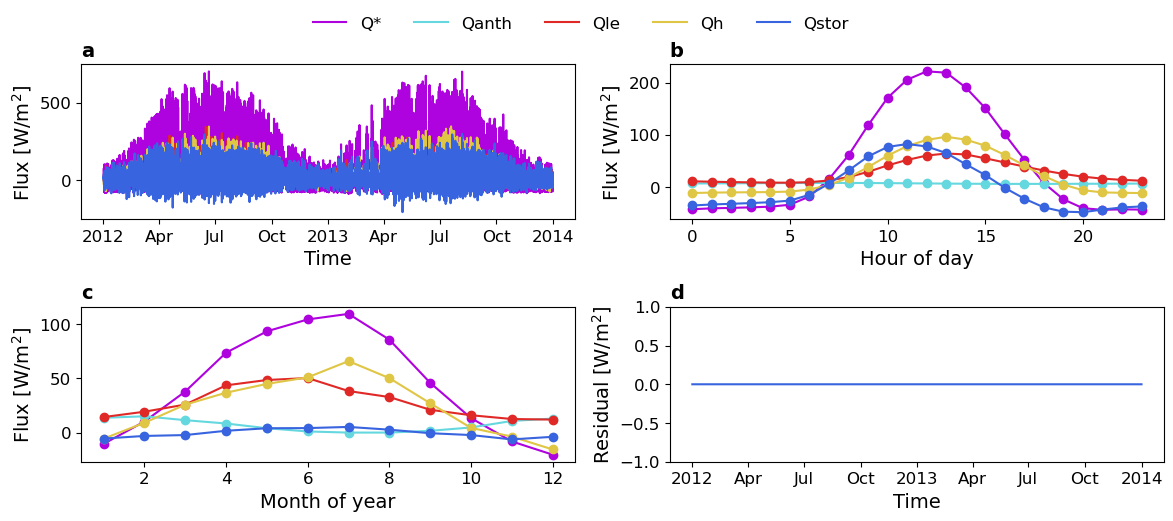

In [6]:
fig = plt.figure(figsize=(12, 5))

axs = fig.subplots(2, 2)

#ds_usp['Qanth'] = ds_usp['URBAN_HEAT'] + ds_usp['WASTEHEAT'] - ds_usp['EFLXBUILD']
ds_usp['Qanth'] = ds_usp['WASTEHEAT'] + ds_usp['URBAN_HEAT']
ds_usp['Qstor'] = ds_usp['FGR'] + ds_usp['URBAN_HEAT'] - ds_usp['URBAN_AC']
ds_usp_h = ds_usp[['Rnet','Qle', 'Qh', 'Qstor','Qanth']].isel(gridcell=0).groupby('time.hour')
h = ds_usp_h.mean('time')
color_list = ["#AE02DE", "#65D8DF","#E02927","#E0C645","#3964DF"]

ds_usp_month = ds_usp[['Rnet','Qanth','Qle', 'Qh', 'Qstor']].isel(gridcell=0).groupby('time.month')
m = ds_usp_month.mean('time')

for i, var in enumerate(['Rnet','Qanth','Qle', 'Qh', 'Qstor']):
    if var == 'Rnet':
        label = 'Q*'
    else:
        label = var
    ds_usp[var].plot(ax=axs[0,0], label=label, color=color_list[i])
    m[var].plot(ax=axs[1,0], label=label, color=color_list[i], marker='o')
    h[var].plot(ax=axs[0,1], label=label, color=color_list[i], marker='o')

(ds_usp['Rnet']+ds_usp['Qanth']-ds_usp['Qle']-ds_usp['Qh']-ds_usp['Qstor']).plot(ax=axs[1,1], color='#3964DF')

xlabels = ['Time', 'Hour of day', 'Month of year', 'Time']
ylabels = ['Flux [W/m$\mathrm{^{2}}$]', 'Flux [W/m$\mathrm{^{2}}$]', 'Flux [W/m$\mathrm{^{2}}$]', 'Residual [W/m$\mathrm{^{2}}$]']
titles = ['a', 'b', 'c', 'd']
for ax in axs.flat:
    ax.set_xlabel(xlabels.pop(0), fontsize=14)
    ax.set_ylabel(ylabels.pop(0), fontsize=14)
    ax.set_title(titles.pop(0), loc='left', fontweight='bold', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
axs[1,1].set_ylim(-1,1)
fig.legend(['Q*','Qanth','Qle','Qh','Qstor'], loc='upper center', frameon=False, ncol=5, bbox_to_anchor=(0.5, 1.05), fontsize=12)

plt.tight_layout()
plt.savefig('figs/exp1_usp_energy.pdf', dpi=300, bbox_inches='tight')
plt.show()

**buiding energy consumption**

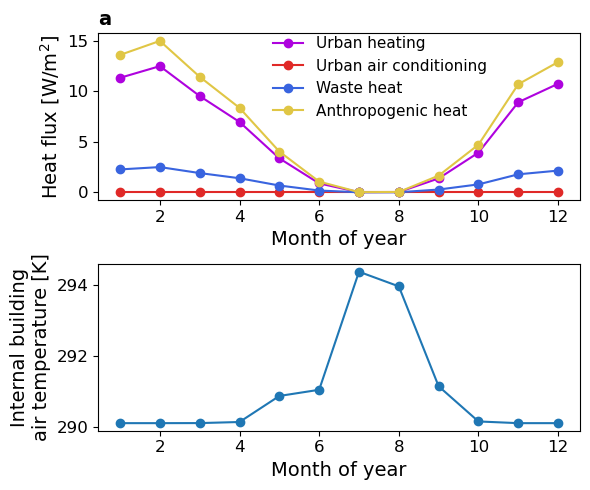

In [7]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(211)
color_list = ["#AE02DE","#E02927","#3964DF"]
tot = ds_usp.sel(gridcell=0)
tot['TOTQANTH'] = tot['URBAN_HEAT'] + tot['WASTEHEAT']
tot = tot[['URBAN_HEAT','URBAN_AC','WASTEHEAT', 'TOTQANTH']].groupby('time.month').mean('time')
tot['URBAN_HEAT'].plot(ax=ax, label='Urban heating', marker='o', color=color_list.pop(0))
tot['URBAN_AC'].plot(ax=ax, label='Urban air conditioning', marker='o', color=color_list.pop(0))
tot['WASTEHEAT'].plot(ax=ax, label='Waste heat', marker='o', color=color_list.pop(0))
tot['TOTQANTH'].plot(ax=ax, label='Anthropogenic heat', marker='o', color='#E0C645')
ax.set_xlabel('Month of year', fontsize=14)
ax.set_ylabel('Heat flux [W/m$\mathrm{^{2}}$]', fontsize=14)
ax.set_title('a', loc='left', fontweight='bold', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(frameon=False, fontsize=11, loc=(0.35,0.45))

ax = fig.add_subplot(212)
tot = ds_usp.sel(gridcell=0)['TBUILD'].groupby('time.month').mean('time').plot(ax=ax, marker='o')
ax.set_xlabel('Month of year', fontsize=14)
ax.set_ylabel('Internal building\nair temperature [K]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig('figs/exp1_usp_urban_bem.pdf', dpi=300)
plt.show()

**column level temperature**

In [8]:
ds_usp_col=usp.nc_view(usp_london[0]).isel(time=slice(2, None))
ds_usp_col

<xarray.Dataset> Size: 134MB
Dimensions:             (levgrnd: 25, levlak: 10, levdcmp: 1, time: 35086,
                         hist_interval: 2, lndgrid: 1, gridcell: 1,
                         landunit: 2, column: 6, pft: 6, levsoi: 20)
Coordinates:
  * levgrnd             (levgrnd) float32 100B 0.01 0.04 0.09 ... 28.87 42.0
  * levlak              (levlak) float32 40B 0.05 0.6 2.1 ... 25.6 34.33 44.78
  * levdcmp             (levdcmp) float32 4B 1.0
  * time                (time) datetime64[ns] 281kB 2012-01-01T01:30:00 ... 2...
Dimensions without coordinates: hist_interval, lndgrid, gridcell, landunit,
                                column, pft, levsoi
Data variables: (12/121)
    mcdate              (time) int32 140kB ...
    mcsec               (time) int32 140kB ...
    mdcur               (time) int32 140kB ...
    mscur               (time) int32 140kB ...
    nstep               (time) int32 140kB ...
    time_bounds         (time, hist_interval) datetime64[ns] 561kB ...
    ...                  ...
    URBAN_AC            (time, column) float32 842kB ...
    URBAN_HEAT          (time, column) float32 842kB ...
    WASTEHEAT           (time, column) float32 842kB ...
    WBT                 (time, column) float32 842kB ...
    Wind                (time, column) float32 842kB ...
    ZWT                 (time, column) float32 842kB ...
Attributes: (12/40)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 09/24/24 13:00:45
    source:                                    Community Land Model CLM4.0
    hostname:                                  clmu-app
    ...                                        ...
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          minute_30
    Time_constant_3Dvars_filename:             ./example1.clm2.h0.2012-01-01-...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

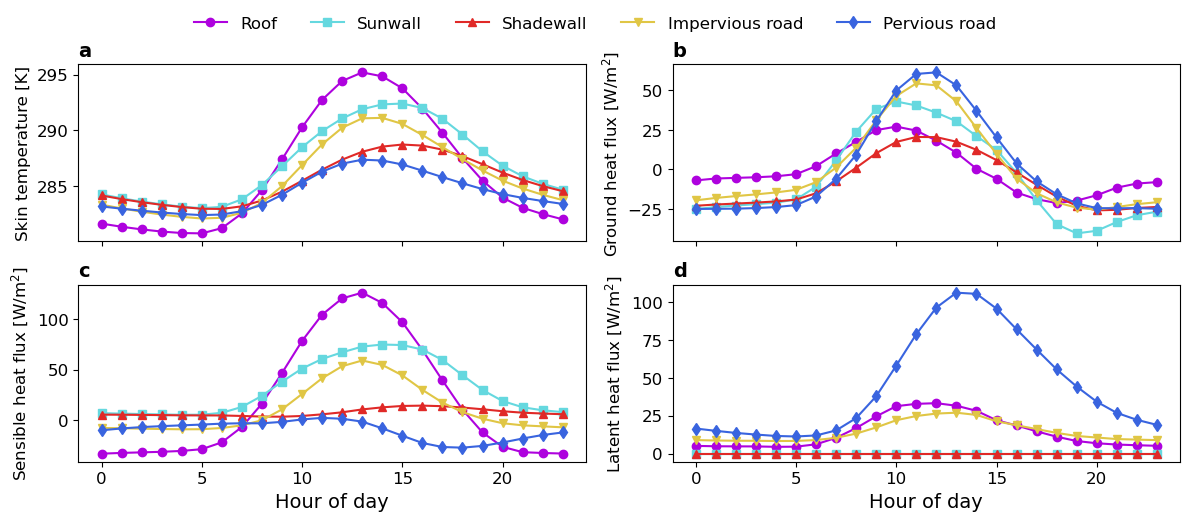

In [9]:
ds_usp_col=usp.nc_view(usp_london[0]).isel(time=slice(2, None))
ds_usp_col = ds_usp_col.assign_coords({'column':ds_usp_col['cols1d_itype_col']})
fig = plt.figure(figsize=(12, 5))
var_list = ['TSKIN','FGR','FSH','EFLX_LH_TOT']
title = ['a', 'b', 'c', 'd']
color_list = ["#AE02DE", "#65D8DF","#E02927","#E0C645","#3964DF"]
ylabel = {
    'TSKIN':'Skin temperature [K]',
    'FGR':'Ground heat flux [W/m$\mathrm{^{2}}$]',
    'FSH':'Sensible heat flux [W/m$\mathrm{^{2}}$]',
    'EFLX_LH_TOT':'Latent heat flux [W/m$\mathrm{^{2}}$]'
}
markers = ['o', 's', '^', 'v', 'd']
for i, var in enumerate(var_list):
    ax = fig.add_subplot(2, 2, i+1)
    
    for col in range(71,76):
        #ds_usp_col[var].sel(column=col).resample(time='M').mean()\
        ds_usp_col[var].sel(column=col).groupby('time.hour').mean('time')\
            .plot(ax=ax, color=color_list[col-71], marker=markers[col-71])
    
    ax.set_ylabel(ylabel[var], fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    if i in [2,3]:
        ax.set_xlabel('Hour of day', fontsize=14)
    else:
        ax.set_xlabel('')
        ax.set_xticklabels([])
    #ax.legend(frameon=False)
    ax.set_title('')
    ax.set_title(title[i], loc='left', fontweight='bold', fontsize=14)

fig.legend(['Roof','Sunwall','Shadewall','Impervious road','Pervious road'], 
           loc='upper center', frameon=False, ncol=5, bbox_to_anchor=(0.5, 1.05), fontsize=12)
fig.tight_layout()
fig.savefig('figs/exp1_usp_urban_col.pdf', dpi=300, bbox_inches='tight')
plt.show()

**water balance**
$$residual = RAIN + SNOW- EVPA - Qs - Qsb- DelSWE- DelSoilMoist - DelIntercept$$

- RAIN: rain from atmosphere
- SNOW: snow from atmosphere
- EVPA: total evaporation. $EVPA=QVEGT+QVEGE+QSOIL$
- QVEGT: canopy transpiration
- QVEGE: canopy evaporation
- QSOIL: Ground evaporation (soil/snow evaporation + soil/snow sublimation - dew)
- Qs: total runoff. $Qs=QOVER+QH2OSFC$
- Qsb: subsurface drainage. $Qsb=QDRAI+QDRAI_PERCH$
- QDRAI: sub-surface drainage
- QDRAI_PERCH: perched wt drainage
- DelSWE: delta H2OSNO (snow depth (liquid water)) divided by time-step.
- DelSoilMoist: delta SOILH2O (soil moisture) divided by time-step. SOILH2O is the sum of column level SOILLIQ and SOILICE weighed by pervious road (see following code).
- DelIntercept: the delta intercept water of roof and pervious road divided by time-step



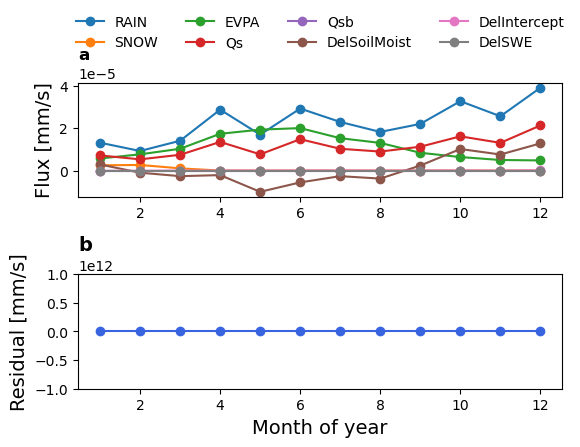

In [10]:
ds_usp=usp.nc_view(usp_london[1])#.isel(time=slice(2, None))
ds_usp_col=usp.nc_view(usp_london[0])#.isel(time=slice(2, None))
ds_usp['EVPA'] = ds_usp['QVEGT'] + ds_usp['QVEGE'] + ds_usp['QSOIL']
ds_usp['Qs'] = ds_usp['QOVER'] + ds_usp['QH2OSFC']
ds_usp['Qsb'] = ds_usp['QDRAI'] + ds_usp['QDRAI_PERCH']
ds_usp['DelSWE'] =ds_usp['H2OSNO'].diff('time')/1800

ds_usp_col = ds_usp_col.assign_coords({'column':ds_usp_col['cols1d_itype_col']})
roof_fra = ds_usp_col['cols1d_wtgcell'].sel(column=71).values
road_imp_fra = ds_usp_col['cols1d_wtgcell'].sel(column=74).values
road_pre_fra = ds_usp_col['cols1d_wtgcell'].sel(column=75).values
ds_usp_col['SOILH2O'] = (1 - roof_fra) \
                        * road_pre_fra / (road_pre_fra + road_imp_fra) \
                        * (ds_usp_col['SOILLIQ'].sel(column=75) + ds_usp_col['SOILICE'].sel(column=75))
#ds_usp_col['SOILH2O'] = road_pre_fra * (ds_usp_col['SOILLIQ'].sel(column=75) + ds_usp_col['SOILICE'].sel(column=75))
ds_usp_col['Intercept'] = roof_fra *\
                            (ds_usp_col['SOILLIQ'].sel(column=71) + ds_usp_col['SOILICE'].sel(column=71))\
                        + (1-roof_fra)*road_imp_fra/(road_pre_fra+road_imp_fra)\
                        * (ds_usp_col['SOILLIQ'].sel(column=74) + ds_usp_col['SOILICE'].sel(column=74))

ds_usp['DelSoilMoist'] = ds_usp_col['SOILH2O'].sum('levsoi').diff('time')/1800
ds_usp['DelIntercept'] = ds_usp_col['Intercept'].sum('levsoi').diff('time')/1800

ds_usp = ds_usp.isel(time=slice(2, None))
water_list = ['RAIN', 'SNOW' ,
              'EVPA', 'Qs', 'Qsb', 'DelSoilMoist', 'DelIntercept', 'DelSWE']
#color_list = ["#E02927","#3964DF","#E0C645","#AE02DE","#65D8DF"]
ds_usp_month = ds_usp[water_list].isel(gridcell=0).groupby('time.month')
tot = ds_usp_month.mean('time')

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(211)
for i, var in enumerate(water_list):

    label = var
    tot[var].plot(ax=ax, marker='o', label=label,) 
    ax.set_xlabel('Month', fontsize=14)
    ax.set_ylabel(var, fontsize=14)

ax.set_xlabel('')
ax.set_ylabel('Flux [mm/s]', fontsize=14)
ax.set_title('a', loc='left', fontweight='bold')
ax.legend(frameon=False, fontsize=10, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.70))

ax = fig.add_subplot(212)

residual = ds_usp['RAIN'] + ds_usp['SNOW'] \
            - ds_usp['EVPA'] - ds_usp['Qs'] - ds_usp['Qsb'] \
            - ds_usp['DelSWE'] \
            - ds_usp['DelSoilMoist'] - ds_usp['DelIntercept']

residual.groupby('time.month').mean('time').plot(ax=ax, marker='o', label='Residual', color='#3964DF')
ax.set_xlabel('Month of year', fontsize=14)
ax.set_ylabel('Residual [mm/s]', fontsize=14)

ax.set_title('b', loc='left', fontweight='bold', fontsize=14)

ax.set_ylim(-1e12,1e12)

plt.tight_layout()
plt.savefig('figs/exp1_usp_water.pdf', dpi=300, bbox_inches='tight')
plt.show()

**human heat stress index**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


TSA [279.59 278.31 280.55 282.82 286.78 289.17 292.96 292.77 289.01 286.21
 281.78 280.45]
HIA [ 6.44  5.16  7.44  9.72 13.81 16.44 20.41 20.58 16.11 13.09  8.63  7.3 ]
SWBGT [10.56  9.43 10.98 12.51 15.65 17.64 20.53 20.55 17.61 15.81 12.2  11.27]
WBT [ 4.19  2.6   4.45  6.15  9.68 11.9  14.66 14.77 11.9  10.3   6.2   5.17]
HUMIDEX [ 5.08  3.23  5.87  8.48 13.7  16.99 21.82 21.82 16.91 13.82  7.83  6.26]


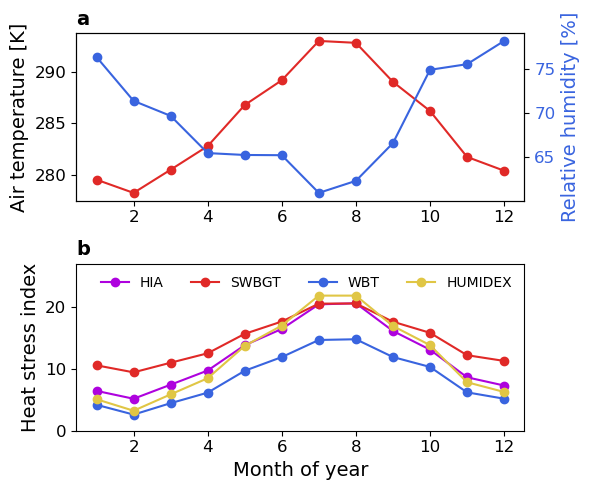

In [11]:
fig = plt.figure(figsize=(6, 5))
dis_list = ['HIA','SWBGT','WBT', 'HUMIDEX']

ax = fig.add_subplot(211)
mean = ds_usp['TSA'].sel(gridcell=0).groupby('time.month').mean('time')
std = ds_usp['TSA'].sel(gridcell=0).groupby('time.month').std('time')
mean.plot(ax=ax, marker='o',color='#E02927')
#ax.fill_between(mean['month'].values, mean - std, mean + std, alpha=0.2, color='#E02927')
ax.set_xlabel('')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylabel('Air temperature [K]', fontsize=14)
ax.set_title('a', loc='left', fontweight='bold', fontsize=14)
ax.legend(frameon=False)
print('TSA', mean.values.round(2))

ax2 = ax.twinx()
mean = ds_usp['RH2M'].sel(gridcell=0).groupby('time.month').mean('time')
mean.plot(ax=ax2, marker='o', color='#3964DF')#color_list = ["#E02927","#3964DF"]
std = ds_usp['RH2M'].sel(gridcell=0).groupby('time.month').std('time')
#ax2.fill_between(mean['month'].values, mean - std, mean + std, alpha=0.2, color='#3964DF')
ax2.set_ylabel('Relative humidity [%]', color='#3964DF', fontsize=14)
ax2.tick_params(axis='y', labelcolor='#3964DF', labelsize=12)

ax = fig.add_subplot(212)
color_list = ["#AE02DE","#E02927","#3964DF","#E0C645"]
tot = ds_usp[dis_list].sel(gridcell=0)

for var in dis_list:
    mean = tot[var].groupby('time.month').mean('time')
    std = tot[var].groupby('time.month').std('time')
    color = color_list.pop(0)
    mean.plot(ax=ax, label=var, marker='o', color=color)
    print(var, mean.values.round(2))
    #ax.plot(mean, label=var, marker='o', color=color_list.pop(0))
    #ax.fill_between(mean['month'].values, mean - std, mean + std, alpha=0.2, color=color)

ax.set_ylim(0, 27)
ax.set_xlabel('Month of year', fontsize=14)
ax.set_ylabel('Heat stress index', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title('b', loc='left', fontweight='bold', fontsize=14)
ax.legend(frameon=False, fontsize=10, ncol=4, loc='upper right')

plt.tight_layout()
plt.savefig('figs/exp1_usp_urban_heat_stress.pdf', dpi=300)
plt.show()

In [12]:
usp.case_clean()

**stop and remove the container**

In [13]:
usp.docker("stop")
usp.docker("rm")